# 🔹 C. Tree-Based Models  
## 4. Random Forest

---

### 📖 What This Notebook Covers

- 🌳 **Intuition & Why Random Forests Work**  
  - Variance reduction, decorrelated trees

- 🏗️ **Step-by-Step Algorithm**  
  - Training & prediction

- 🧮 **Key Equations**  
  - Bagging average, OOB estimate, feature importance summary

- 🎨 **Visualizations**  
  - Decision boundaries, OOB error curve, feature importance barplot

- 💻 **`scikit-learn` Usage**  
  - `RandomForestClassifier`, `RandomForestRegressor`

- 🏗️ **From-Scratch RandomForest Class**  
  - Bagging of decision trees + feature subsampling

- ⚙️ **Hyperparameter Tuning, Complexity, Pros/Cons, Practical Tips**


# 🌳 Intuition (High-Level) & How Random Forest Improves Over Single Trees

---

## 🔹 Intuition

- A **Random Forest** builds an **ensemble of decision trees** and aggregates their predictions:  
  - **Classification:** majority vote  
  - **Regression:** average  

- Each tree is trained on a **bootstrap sample** of the data (**bagging**) and, at each split, a **random subset of features** is considered (**feature subsampling**).  

- This **reduces correlation between trees**, so averaging reduces variance without increasing bias much — producing a **powerful, robust model**.

---

## 🔹 When to Use Random Forests

- Tabular data problems (**classification** and **regression**)  
- When you want **good baseline performance** with minimal tuning  
- When **interpretability at the feature-importance level** is useful (but not per-observation rules)


# 🏗️ Step-by-Step Algorithm (Classification; Regression is Analogous)

---

### 1️⃣ Training

For `b = 1` to `B` (number of trees):

- Draw a **bootstrap sample** (sample $n$ training examples **with replacement**).  
- Train a **decision tree** on that sample. At each candidate split, consider a **random subset of $m$ features**:  
  - Usually $m = \sqrt{p}$ for classification  
  - $m = p/3$ for regression  

- Grow the tree fully (or with pruning constraints like `max_depth` or `min_samples_leaf`).

---

### 2️⃣ Prediction for a New Sample $x$

- Each tree outputs a predicted class $\hat{y}_b(x)$.  
- Aggregate predictions:  
  - **Classification:** majority vote  
  - **Regression:** average



# 🧮 Key Equations

---

## Bagging Prediction (Regression)

Ensemble prediction (average):

$$
\hat{f}_{\text{RF}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}_b(x)
$$

---

## Bagging Prediction (Classification — Class Probabilities)

If tree $b$ outputs class probabilities $\hat{p}_b(y=c \mid x)$:

$$
\hat{p}_{\text{RF}}(y=c \mid x) = \frac{1}{B} \sum_{b=1}^B \hat{p}_b(y=c \mid x)
$$

Then predict the class:

$$
\hat{y} = \arg\max_c \hat{p}_{\text{RF}}(y=c \mid x)
$$

---

## Out-of-Bag (OOB) Estimate (Approximate Cross-Validation)

For each training sample $i$, let $\mathcal{B}_{-i}$ be the set of trees that **did not** include $i$ in their bootstrap sample.  

The OOB predicted value:

$$
\hat{f}_{\text{OOB}}(x_i) = \frac{1}{|\mathcal{B}_{-i}|} \sum_{b \in \mathcal{B}_{-i}} \hat{f}_b(x_i)
$$

Use OOB predictions to estimate **generalization error** without a separate validation set.


# ✅ Advantages & ❌ Limitations

---

## Advantages

- 💪 High predictive performance **out-of-the-box**.  
- 🛡️ Robust to **outliers** and **noise**.  
- 🌳 Handles **numeric** & **categorical** features (with preprocessing).  
- 📊 Provides **feature importance** measures.  
- 🔹 **OOB estimate** gives internal validation.

---

## Limitations

- 🧐 Less interpretable than a single decision tree.  
- 💾 Can be **large in memory** (many trees).  
- ⚡ Can be slower for **real-time prediction**, though predictions are parallelizable.  
- ⚠️ Feature importances (Gini) can be biased toward **continuous or high-cardinality features**.


In [1]:
# Cell 6 — Imports and helper plotting functions

# Paste as Python cell.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_blobs, make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8,5)

# helper to plot decision regions for 2D data
def plot_decision_regions(model, X, y, title=None, mesh_step=0.05, eps=0.6, cmap='viridis'):
    x_min, x_max = X[:,0].min() - eps, X[:,0].max() + eps
    y_min, y_max = X[:,1].min() - eps, X[:,1].max() + eps
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step),
                         np.arange(y_min, y_max, mesh_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolor='k', s=40)
    if title:
        plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# 🧩 Synthetic 2D Classification Dataset for Visualization

---

We'll create a **2D dataset** so that **decision boundaries** can be easily visualized.


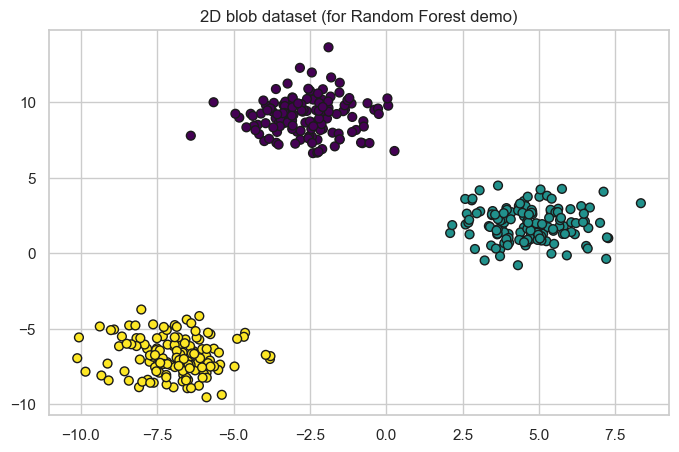

In [2]:
# Cell 8 — generate data
X, y = make_blobs(n_samples=400, centers=3, cluster_std=1.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("2D blob dataset (for Random Forest demo)")
plt.show()


# 🌳 scikit-learn RandomForestClassifier Usage (Basic)

---

We'll **fit a Random Forest classifier**, **evaluate its performance**, and **plot the decision regions**.



Train accuracy: 1.0
Test accuracy: 1.0
OOB score: 1.0


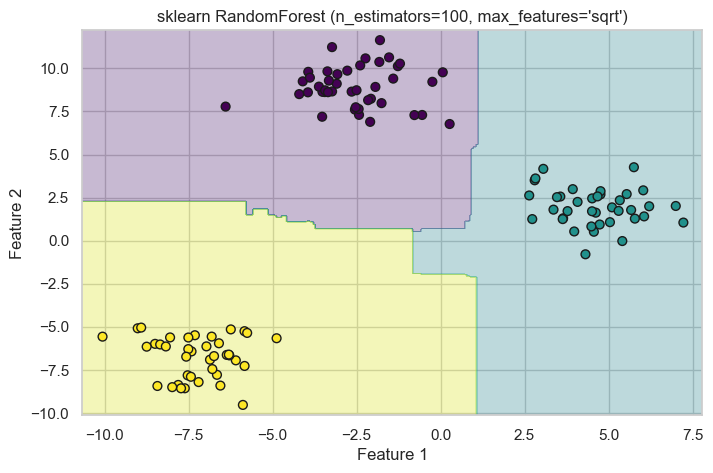

In [3]:
# Cell 10 — sklearn RF fit and visualize
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=0, oob_score=True)
rf.fit(X_train, y_train)
print("Train accuracy:", rf.score(X_train, y_train))
print("Test accuracy:", rf.score(X_test, y_test))
# OOB score (approx CV on training set)
print("OOB score:", getattr(rf, "oob_score_", None))

plot_decision_regions(rf, X_test, y_test, title="sklearn RandomForest (n_estimators=100, max_features='sqrt')")


# 📊 Feature Importance (Gini Importance)

---

Random Forests compute **feature importances** by averaging **impurity decrease** across all trees for each feature.  

We'll demonstrate **feature importance** on a **synthetic dataset** with informative features.


Feature 0: importance = 0.0842
Feature 1: importance = 0.0800
Feature 2: importance = 0.0733
Feature 3: importance = 0.0791
Feature 4: importance = 0.1351
Feature 5: importance = 0.5483


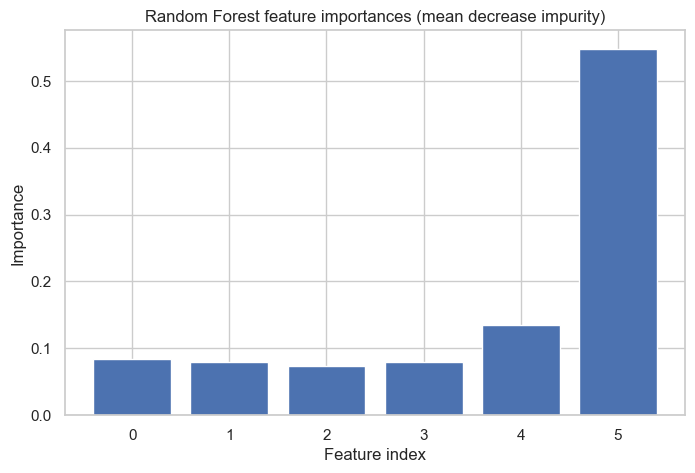

In [4]:
# Cell 12 — feature importance demo
Xf, yf = make_classification(n_samples=500, n_features=6, n_informative=2, n_redundant=0, random_state=0)
rf2 = RandomForestClassifier(n_estimators=200, random_state=0)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3, random_state=0)
rf2.fit(Xf_train, yf_train)
importances = rf2.feature_importances_
for i, imp in enumerate(importances):
    print(f"Feature {i}: importance = {imp:.4f}")
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Random Forest feature importances (mean decrease impurity)")
plt.show()


# 📈 OOB Error Curve vs Number of Trees

---

We'll demonstrate how the **Out-Of-Bag (OOB) error** stabilizes as we **increase `n_estimators`** in a Random Forest.


d:\Python\ml-basics\.venv\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


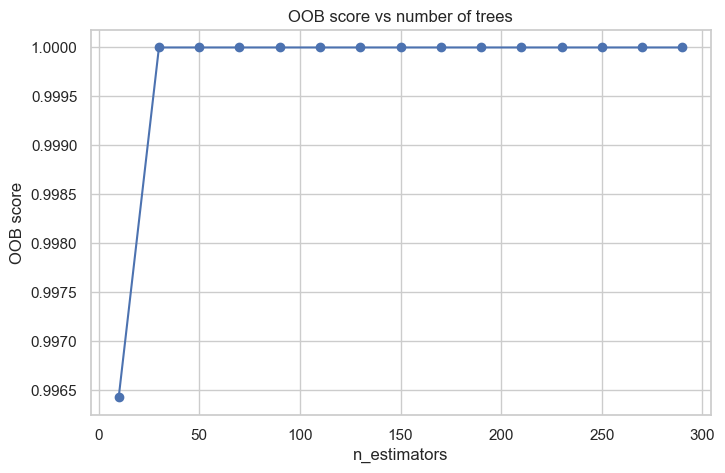

In [5]:
# Cell 14 — OOB error vs n_estimators
oob_scores = []
n_list = list(range(10, 301, 20))
for n in n_list:
    rf_temp = RandomForestClassifier(n_estimators=n, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=0)
    rf_temp.fit(X_train, y_train)
    oob_scores.append(rf_temp.oob_score_)

plt.plot(n_list, oob_scores, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("OOB score")
plt.title("OOB score vs number of trees")
plt.show()


# 🌳 Random Forest Regression Example (scikit-learn)

---

We'll demonstrate **piecewise averaged predictions** of a Random Forest compared to a **single Decision Tree**.


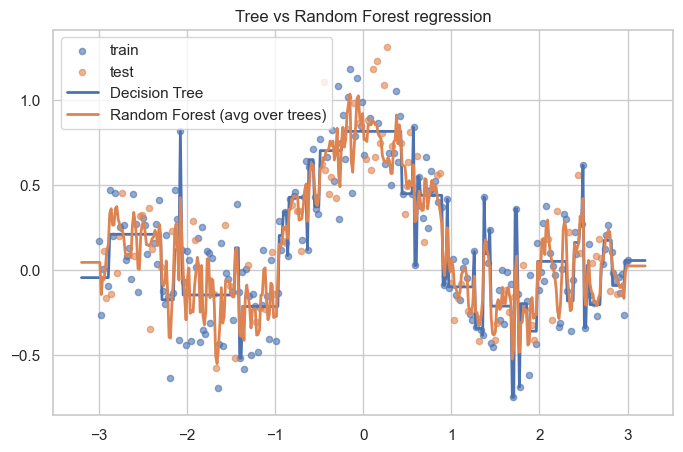

DT test MSE: 0.05372895999864189
RF test MSE: 0.06708551267308593


In [6]:
# Cell 16 — regression demo
Xr = np.linspace(-3, 3, 300).reshape(-1,1)
yr = np.sinc(Xr[:,0]) + 0.25 * np.random.randn(len(Xr))
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=2)

# Decision tree regressor for comparison
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=6, random_state=0)
dtr.fit(Xr_train, yr_train)
# Random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_features=1, random_state=0)
rfr.fit(Xr_train, yr_train)

X_grid = np.linspace(Xr.min()-0.2, Xr.max()+0.2, 400).reshape(-1,1)
y_pred_tree = dtr.predict(X_grid)
y_pred_rf = rfr.predict(X_grid)

plt.scatter(Xr_train, yr_train, s=20, alpha=0.6, label='train')
plt.scatter(Xr_test, yr_test, s=20, alpha=0.6, label='test')
plt.plot(X_grid, y_pred_tree, label='Decision Tree', linewidth=2)
plt.plot(X_grid, y_pred_rf, label='Random Forest (avg over trees)', linewidth=2)
plt.legend()
plt.title("Tree vs Random Forest regression")
plt.show()

print("DT test MSE:", mean_squared_error(yr_test, dtr.predict(Xr_test)))
print("RF test MSE:", mean_squared_error(yr_test, rfr.predict(Xr_test)))


# ⚙️ Hyperparameter Tuning (Brief Guide)

---

### Important Hyperparameters

- 🌲 `n_estimators`: Number of trees (more → better, but with **diminishing returns**).  
- 📐 `max_features`: Features considered at each split  
  - Common defaults: $\sqrt{p}$ for classification, $p/3$ for regression.  
- 🛡️ `max_depth`, `min_samples_leaf`, `min_samples_split`: Control **tree size** — help reduce overfitting.  
- 🔄 `bootstrap`: Whether to use **bootstrap samples** (default = True).  
- 📊 `oob_score`: Use **Out-Of-Bag score** as a CV estimate when `bootstrap=True`.  

---

💡 Use **`GridSearchCV`** with `n_jobs=-1` to tune hyperparameters efficiently.  
Example in the next cell.


In [7]:
# Cell 18 — GridSearchCV example (classification)
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
rf_grid = RandomForestClassifier(random_state=0)
gs = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(Xf_train, yf_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)


Best params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best CV score: 0.8742857142857143


# 🏗️ From-Scratch Random Forest (Bagging + Feature Subsampling)

---

We'll implement a **simple RandomForest class** that:

- 🌳 **Classification:** Aggregates votes across trees (**majority vote**).  
- 📊 **Regression:** Averages predictions across trees.  

### Implementation Details

- Each tree is a `sklearn.tree.DecisionTreeClassifier` (or `DecisionTreeRegressor`) — the **heavy lifting of tree building is delegated**.  
- Implements **bootstrap sampling** (with replacement) and **feature subsampling** (`max_features`) per tree.  
- Computes an **approximate OOB score** (for classification).  
- Computes **feature importance** as the **average of `feature_importances_`** across trees.

💡 This is a **clean, educational “from-scratch” ensemble wrapper** — not re-implementing tree induction itself, but implementing the **ensemble logic**.


In [8]:
# Cell 20 — From-scratch RandomForest class (uses sklearn trees internally)
from sklearn.base import clone
from collections import Counter
import math

class SimpleRandomForest:
    def __init__(self, base_estimator, n_estimators=100, max_features='sqrt', bootstrap=True, random_state=None, task='classification'):
        """
        base_estimator: a sklearn DecisionTreeClassifier or DecisionTreeRegressor instance (unfitted)
        max_features: 'sqrt', 'log2', None, or int number of features, or float fraction (0,1]
        bootstrap: whether to bootstrap samples per tree
        task: 'classification' or 'regression'
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = np.random.RandomState(random_state)
        self.task = task
        self.trees = []
        self.features_indices = []  # feature subsets per tree
        self.oob_indices = []       # OOB sample indices per tree
    
    def _get_max_features(self, p):
        if self.max_features is None:
            return p
        if isinstance(self.max_features, int):
            return self.max_features
        if isinstance(self.max_features, float):
            return max(1, int(self.max_features * p))
        if self.max_features == 'sqrt':
            return max(1, int(math.sqrt(p)))
        if self.max_features == 'log2':
            return max(1, int(math.log2(p)))
        raise ValueError("Unsupported max_features")
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, p = X.shape
        self.n_features_ = p
        self.classes_ = np.unique(y) if self.task=='classification' else None
        
        self.trees = []
        self.features_indices = []
        self.oob_indices = []
        
        for b in range(self.n_estimators):
            # bootstrap sample indices
            if self.bootstrap:
                sample_idx = self.random_state.randint(0, n_samples, size=n_samples)
                oob_idx = np.setdiff1d(np.arange(n_samples), sample_idx, assume_unique=False)
            else:
                # use full data, no OOB
                sample_idx = np.arange(n_samples)
                oob_idx = np.array([], dtype=int)
            # feature subset
            k = self._get_max_features(p)
            feat_idx = self.random_state.choice(np.arange(p), size=k, replace=False)
            # create train subset
            X_sub = X[sample_idx][:, feat_idx]
            y_sub = y[sample_idx]
            # clone base estimator and fit
            tree = clone(self.base_estimator)
            # force tree to consider only selected features by fitting on X_sub
            tree.fit(X_sub, y_sub)
            self.trees.append(tree)
            self.features_indices.append(feat_idx)
            self.oob_indices.append(oob_idx)
        return self
    
    def predict(self, X):
        X = np.asarray(X)
        all_preds = []
        for tree, feat_idx in zip(self.trees, self.features_indices):
            preds = tree.predict(X[:, feat_idx])
            all_preds.append(preds)
        all_preds = np.array(all_preds)  # shape (n_estimators, n_samples)
        
        if self.task == 'classification':
            # majority vote for each sample
            n_samples = X.shape[0]
            final_preds = []
            for j in range(n_samples):
                votes = all_preds[:, j]
                vote_count = Counter(votes)
                pred = vote_count.most_common(1)[0][0]
                final_preds.append(pred)
            return np.array(final_preds)
        else:
            # regression: average
            return np.mean(all_preds, axis=0)
    
    def predict_proba(self, X):
        # only valid for classification and when trees provide predict_proba
        X = np.asarray(X)
        prob_sum = None
        for tree, feat_idx in zip(self.trees, self.features_indices):
            probs = tree.predict_proba(X[:, feat_idx])
            if prob_sum is None:
                prob_sum = probs
            else:
                prob_sum += probs
        return prob_sum / len(self.trees)
    
    def oob_score(self, X, y):
        # compute OOB predictions for each training sample using trees that did not include it
        X = np.asarray(X)
        y = np.asarray(y)
        n = X.shape[0]
        preds_oob = [ [] for _ in range(n) ]
        for tree, feat_idx, oob_idx in zip(self.trees, self.features_indices, self.oob_indices):
            if len(oob_idx)==0:
                continue
            pred_oob = tree.predict(X[oob_idx][:, feat_idx])
            for i, idx in enumerate(oob_idx):
                preds_oob[idx].append(pred_oob[i])
        # aggregate per sample
        y_pred_oob = np.zeros(n, dtype=object if self.task=='classification' else float)
        valid = np.zeros(n, dtype=bool)
        for i in range(n):
            if len(preds_oob[i])==0:
                continue
            valid[i] = True
            if self.task=='classification':
                y_pred_oob[i] = Counter(preds_oob[i]).most_common(1)[0][0]
            else:
                y_pred_oob[i] = np.mean(preds_oob[i])
        # compute score on valid samples
        mask = valid
        if self.task=='classification':
            return np.mean(y[mask] == y_pred_oob[mask])
        else:
            return -np.mean((y[mask] - y_pred_oob[mask])**2)
    
    def feature_importances_(self):
        # average feature_importances_ across trees, mapping back to original feature indices
        importances = np.zeros(self.n_features_)
        for tree, feat_idx in zip(self.trees, self.features_indices):
            if hasattr(tree, 'feature_importances_'):
                imp = tree.feature_importances_
                # imp corresponds to selected features in feat_idx
                for val, fi in zip(imp, feat_idx):
                    importances[fi] += val
        importances = importances / len(self.trees)
        return importances


# 🧪 Test SimpleRandomForest (Classification) on 2D Blobs

---

We'll use `DecisionTreeClassifier()` as the **base estimator** and **compare performance** with scikit-learn's `RandomForestClassifier`.


SimpleRandomForest test accuracy: 1.0
sklearn RandomForest test accuracy: 1.0
SimpleRandomForest OOB score (approx): 1.0
sklearn RF OOB: 1.0


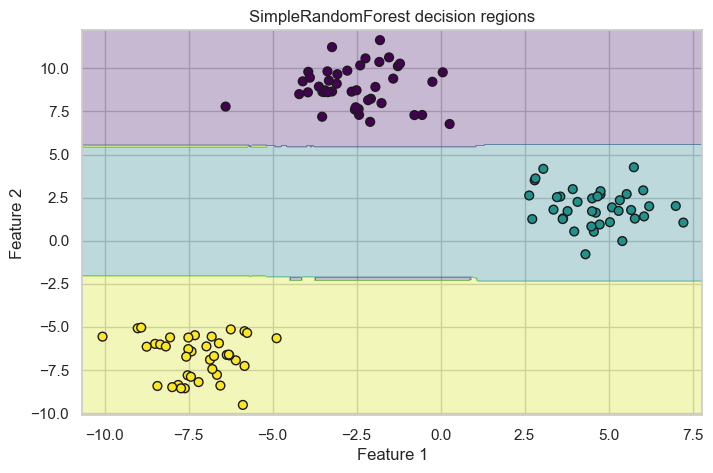

In [10]:
# Cell 22 — fit and compare
from sklearn.tree import DecisionTreeClassifier

base_tree = DecisionTreeClassifier(random_state=0, max_depth=None)
srf = SimpleRandomForest(base_estimator=base_tree, n_estimators=100, max_features='sqrt', bootstrap=True, random_state=0, task='classification')
srf.fit(X_train, y_train)
y_pred_srf = srf.predict(X_test)
print("SimpleRandomForest test accuracy:", np.mean(y_pred_srf == y_test))
print("sklearn RandomForest test accuracy:", rf.score(X_test, y_test))

# OOB approximate score
print("SimpleRandomForest OOB score (approx):", srf.oob_score(X_train, y_train))
print("sklearn RF OOB:", rf.oob_score_)

# Decision boundary using our wrapper (we'll create a wrapper to call predict on grid)
class WrapperSRF:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict(X)

plot_decision_regions(WrapperSRF(srf), X_test, y_test, title="SimpleRandomForest decision regions")


# 📊 Feature Importance: SimpleRandomForest

---

We'll compute **averaged feature importances** from our `SimpleRandomForest` model and **visualize them** with a plot.


Feature 0: importance = 0.4100
Feature 1: importance = 0.5900


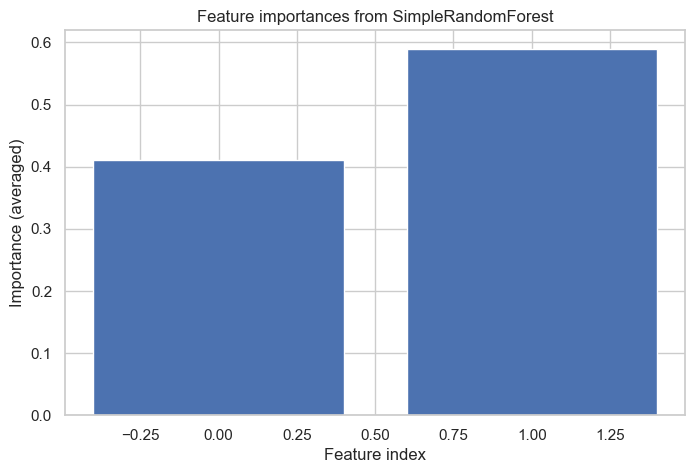

In [11]:
# Cell 24 — compute & plot importances
imp_srf = srf.feature_importances_()
for i, imp in enumerate(imp_srf):
    print(f"Feature {i}: importance = {imp:.4f}")
plt.bar(range(len(imp_srf)), imp_srf)
plt.xlabel("Feature index")
plt.ylabel("Importance (averaged)")
plt.title("Feature importances from SimpleRandomForest")
plt.show()


# Cell 25 — Notes on Our From-Scratch Random Forest Implementation

# ✅ What we implemented:
- Bootstrap sampling per tree (bagging)
- Feature subsampling per tree (`max_features`)
- Aggregation of predictions:
  - Majority vote for classification
  - Average for regression
- Out-of-Bag (OOB) scoring:
  - Aggregates predictions from trees that did **not** include a given sample
- Feature importances:
  - Averaged across all trees

# ⚠ Differences from production RandomForest implementations:
- We used `sklearn` DecisionTree as the base estimator
  - Fully reimplementing CART would be more complex
- `sklearn` RandomForest performs more optimizations:
  - Parallel builds
  - Better handling of categorical data
  - Slightly different default heuristics
- Our OOB computation is basic but illustrative


# ⚙️ Complexity & Scaling Notes

---

## Complexity

- 🏋️ **Training:** $O(B \cdot \text{complexity\_of\_tree\_training})$  
  - Tree training depends on **n_samples**, **n_features**, and **depth**.  

- ⚡ **Prediction:** $O(B \cdot \text{time\_per\_tree\_prediction})$  
  - Can be **parallelized**.  

- 💾 **Memory:** Stores $B$ trees.

---

## Practical Tips

- 📈 Increase `n_estimators` until **OOB/test error stabilizes**.  
- 🌳 Use `max_features` to control **tree correlation**  
  - Lower `max_features` → less correlated trees → larger **variance reduction**.  
- 🛡️ Control **tree depth** with `max_depth` / `min_samples_leaf` to avoid overfitting.  
- 🔄 Use `warm_start=True` in sklearn to **grow the ensemble incrementally**.  
- ⚡ Consider `n_jobs=-1` to **train trees in parallel** (sklearn).


# ✅ Pros & ❌ Cons Summary

---

## Pros

- 💪 Strong off-the-shelf performance for many tasks.  
- 🛡️ Robust to overfitting compared to single decision trees.  
- 🌳 Handles **missing values** & **mixed feature types** (with adaptations).  
- 📊 Provides **feature importance** and **OOB estimates**.

---

## Cons

- 🧐 Less interpretable than a single tree.  
- 💾 Models can be large; **memory** and **inference time** matter in production.  
- ⚠️ Feature importances can be **biased** toward features with many categories or larger ranges.


# 🧪 Extra Experiments to Try

---

1. 🌳 Compare **RandomForest** vs **single DecisionTree** vs **Gradient Boosting** on a real dataset (e.g., Iris, Wine, or a Kaggle dataset).  
2. 📏 Measure the effect of `max_features` on **correlation between trees**:  
   - Compute **pairwise prediction correlation** of trees for the validation set.  
3. 🔄 Try **permutation importances** as an unbiased alternative to Gini importances.  
4. ➕ Use `warm_start=True` to **add trees incrementally** and plot **OOB vs n_estimators**.  
5. ⚡ For very large datasets, try **hist-gradient-boosting** or approximate methods;  
   for very high-dimensional sparse data, tune `max_features` carefully.


# 🎬 Closing & Further Reading

---

Random Forests are a **core, reliable ensemble method**. They are excellent **baseline models** and a **building block** for many pipelines.

### Next Steps

- 🌳 Learn **Random Forest internals**, e.g., impurity calculations per split.  
- 📊 Study **ensemble theory**, including bias-variance decomposition.  
- ⚡ Explore **advanced ensemble methods**: Gradient Boosting Machines such as **XGBoost, LightGBM, CatBoost**.

---

✅ **End of Random Forest Notebook**
